# Notebook 2 : UK data analysis + LDA + Filtering the top 20 newspapers

In [2]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Filter out the non relevant tags and subdomains of the top 20 domains + Notebook 1 cleaning :

* the table with the top 20 domains and their relevant tags can be found under "domain filtering.pdf"

In [3]:
relevant= ["bbc.co.uk/news/",
"Ablink.editorial.theguardian.com",
"theguardian.com/news/",
"theguardian.com/world/",
"theguardian.com/commentisfree/",
"theguardian.com/us-news/",
"theguardian.com/uk-news/",
"theguardian.com/politics/",
"theguardian.com/education/",
"theguardian.com/society/",
"theguardian.com/science/",
"theguardian.com/business/",
"theguardian.com/money/",
"theguardian.com/sport/",
"theguardian.com/australia-news/",
"theguardian.com/travel/",
"theguardian.com/technology/",
"theguardian.com/commentisfree/",
"dailymail.co.uk/news/",
"dailymail.co.uk/columnists/",
"dailymail.co.uk/debate/",
"dailymail.co.uk/femail/",
"dailymail.co.uk/health/",
"dailymail.co.uk/money/",
"dailymail.co.uk/sport/",
"dailymail.co.uk/travel/",
"dailymail.co.uk/tvshowbiz/",
"news.sky.com/story/",
"thesun.co.uk/fabulous/",
"thesun.co.uk/money/",
"thesun.co.uk/news/",
"thesun.co.uk/sport/",
"thesun.co.uk/travel/",
"thesun.co.uk/tech/",
"www.telegraph.co.uk/politics/",
"www.telegraph.co.uk/news/",
"express.co.uk",
"metro.co.uk",
"itv.com/news",
"independent.co.uk/news",
"thetimes.co.uk/article",
"www.channel4.com/news",
"inews.co.uk/news",
"thetelegraphandargus.co.uk/news",
"nytimes.com/20",
"standard.co.uk/news",
"kentonline.co.uk",
"ft.com/content",
"eveningtimes.co.uk/news",
"eveningtimes.co.uk/content"]

In [4]:
news = pd.DataFrame()
DATA_FILES = ['uk/newspaper.json']
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)

In [296]:
len(news)

120585

In [297]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty
len(media_portals)

118487

In [6]:
media_portals=media_portals[media_portals.url.str.contains('|'.join(relevant))]

In [7]:
media_portals=media_portals[media_portals["url"].str.contains("express.co.uk/showbiz|discountcode.metro.co.uk|Link.news.metro.co.uk|www.metro.co.uk|api.metro.co.uk")==False]
media_portals

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk
7,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
8,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
20,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk
21,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
120568,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk
120569,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk
120576,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk
120579,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk


## check how many articles we have with all the tags from the top 20:

In [8]:
alltwenty= ["bbc.co.uk",
"theguardian.com",
"dailymail.co.uk",
"sky.com",
"thesun.co.uk",
"www.telegraph.co.uk",
"express.co.uk",
"metro.co.uk",
"itv.com",
"independent.co.uk",
"thetimes.co.uk",
"www.channel4.com",
"inews.co.uk",
"thetelegraphandargus.co.uk",
"nytimes.com",
"standard.co.uk",
"kentonline.co.uk",
"ft.com",
"eveningtimes.co.uk",
"buzzfeed.com"]

In [9]:
len(news[news.url.str.contains('|'.join(alltwenty))])

86346

## Checking the number of occurences of articles based on title and text seperately :

In [10]:
news[news.text.str.contains("That's why our new email newsletter will deliver a mobile-friendly snapshot of inews.co.uk", case=False, na=False)]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1146,Mendip House care home has been fined a deriso...,The i's Essential Daily Briefing\n\nWe know th...,[Ian Birrell],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_74657_web_page.html,inews.co.uk/opinion/columnists/mendip-house-au...,NaN,uk
1172,The lesbian ‘blood sisters’ who cared for gay ...,The i's Essential Daily Briefing\n\nWe know th...,[Dr Kate Lister],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78007_web_page.html,inews.co.uk/opinion/comment/the-lesbian-blood-...,NaN,uk
1173,‘There were days we couldn’t buy food’: why as...,The i's Essential Daily Briefing\n\nWe know th...,[Nahla Ellozi],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78008_web_page.html,inews.co.uk/opinion/why-asylum-seekers-should-...,NaN,uk
2595,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8058_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
2596,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8059_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
93204,Michael Gove to challenge Boris Johnson for To...,The i's Essential Daily Briefing\n\nWe know th...,[Nick Duffy],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_23048_web_page.html,inews.co.uk/news/politics/michael-gove-to-chal...,NaN,uk
93502,Can UK enter Eurovision after Brexit? How leav...,The i's Essential Daily Briefing\n\nWe know th...,[Charlie Duffield],[https://edition.pagesuite-professional.co.uk/...,None,en,[],GER_2019-05-26_43942_web_page.html,inews.co.uk/news/brexit/eurovision-2019-brexit...,NaN,uk
93503,Matt Hancock warns the next Prime Minister not...,The i's Essential Daily Briefing\n\nWe know th...,[Georgina Littlejohn],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_43943_web_page.html,inews.co.uk/news/matt-hancock-warns-next-prime...,NaN,uk
93600,Nigel Farage ‘will take over’ as leader of the...,The i's Essential Daily Briefing\n\nWe know th...,[Serina Sandhu],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_48204_web_page.html,inews.co.uk/news/nigel-farage-leader-brexit-pa...,NaN,uk


In [11]:
pd.DataFrame(media_portals.text.value_counts())

text
The i's Essential Daily Briefing\n\nWe know tha...   349
What term do you want to search? Search with go...   278
Make informed decisions with the FT\n\nKeep abr...   171
Have Your Say                                         56
i Search\n\nCheck the URL for errors or try our...    52
...                                                  ...
Mr Farage mocked today’s news that embattled Mr...     1
BRITISH holidaymakers are being conned out of m...     1
ICELAND shoppers can get a blast from the past ...     1
BARGAIN hunters are going wild for £8.99 glitte...     1
THIS is the shocking moment a vicious maniac sa...     1

[30193 rows x 1 columns]

In [12]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

In [13]:
criteria=50
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 50 :36541
Number of articles with title occurence less than 50 :37373
Number of articles with title and text occurence combined less than 50 :36265


## Data preprocessing :

In [299]:
a=s
a=a.drop_duplicates(subset='text', keep='first')
a=a.drop_duplicates(subset='title', keep='first')
len(a)

29131

## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [17]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [18]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [19]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [20]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [21]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [22]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [23]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))

In [24]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[imag, man, lay, flower, victim, terror, attac..."
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl..."
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr..."
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[imag, copyright, getti, imag, imag, lord, ste..."
5,Quiz of the Week: How is Bond going green?,It's the weekly news quiz - have you been payi...,None,[https://sb.scorecardresearch.com/p?c1=2&c2=17...,None,en,[],GER_2019-03-15_2098_web_page.html,www.bbc.co.uk/news/stories-47558696,NaN,uk,2.0,2.0,"[weekli, news, quiz, pay, attent, day, quiz, c..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns..."
36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ..."
36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, come, raci..."
36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, call, vodafon, deal, amaz..."


In [25]:
a['length']=a['clean_text'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Distributon of number of words in the articles')

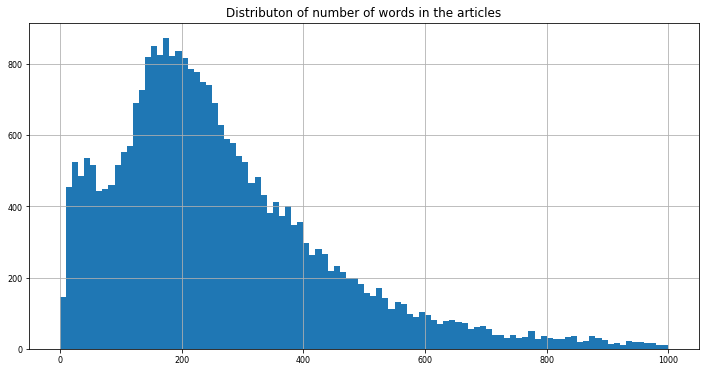

In [28]:
a['length'].hist(figsize=(12, 6), bins=100, xlabelsize=8, ylabelsize=8,range=(0, 1000));
plt.title("Distributon of number of words in the articles")

In [30]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu",
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Keep articles with length more than 50 only 

In [32]:
a=a[a["length"]>50]

In [36]:
a=a.reset_index()

In [ ]:
data_lemmatized = list(a['clean_text'])

In [38]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=1, no_above=0.4)

# Create Corpus
texts = texts

In [40]:
corpus = [id2word.doc2bow(text) for text in texts]

In [41]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 93961
Number of documents: 28205


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """ 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num_topics, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num_topics,
                                                   per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=20, step=1)

-2.088091765115992
-2.4862179910040707
-2.5326088702672167
-2.3466495840572907
-2.3657187849759773
-2.6775428009013824
-2.1509929236005947
-2.015839341516551
-2.0697178781361742
-2.2551165125656194


'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

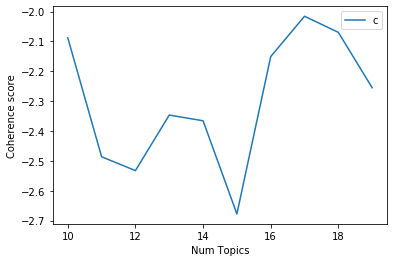

In [46]:
# Show graph
limit=20; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [108]:
num=15
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num,
                                                   per_word_topics=True)

In [109]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=17, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.043*"health" + 0.035*"univers" + 0.024*"studi" + 0.021*"food" + 0.021*"dr" + 0.018*"credit" + 0.016*"risk" + 0.016*"bodi" + 0.016*"drug" + 0.015*"diseas" + 0.013*"eat" + 0.013*"condit" + 0.012*"children" + 0.011*"expert" + 0.011*"professor" + 0.010*"cent" + 0.010*"level" + 0.010*"sugar" + 0.009*"pinterest" + 0.009*"colleg"

1: 0.023*"servic" + 0.017*"pay" + 0.015*"work" + 0.014*"custom" + 0.013*"uk" + 0.013*"govern" + 0.012*"month" + 0.011*"fund" + 0.011*"cost" + 0.010*"pension" + 0.009*"plan" + 0.009*"council" + 0.008*"spend" + 0.008*"offer" + 0.008*"bank" + 0.007*"free" + 0.007*"hous" + 0.007*"busi" + 0.007*"number" + 0.006*"increas"

2: 0.044*"amazon" + 0.041*"school" + 0.028*"price" + 0.026*"sell" + 0.024*"deal" + 0.022*"buy" + 0.021*"store" + 0.019*"free" + 0.017*"email_address" + 0.017*"demonstr" + 0.016*"shop" + 0.015*"product" + 0.014*"sale" + 0.014*"children" + 0.013*"worth" + 0.012*"parent" + 0.012*"save" + 0.010*"uk" + 0.010*"invest" + 0.010*"busi"

3: 0.025*"news" + 0.

In [258]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.166304 -0.061531       1        1  15.216857
7      0.138077  0.059899       2        1  12.259093
12     0.123784  0.065987       3        1  11.668822
11     0.113896  0.082528       4        1  11.307660
4      0.115362 -0.018333       5        1  10.911930
1      0.111172 -0.065241       6        1   8.814806
14     0.060050 -0.163647       7        1   7.526495
5      0.125884  0.051204       8        1   5.703729
3      0.045737  0.043045       9        1   4.054356
9     -0.062908  0.019470      10        1   3.360161
2     -0.098566 -0.200232      11        1   2.487997
0     -0.142161 -0.088015      12        1   2.417239
6     -0.198685  0.058935      13        1   1.801841
13    -0.184555  0.337877      14        1   1.273591
10    -0.313393 -0.121948      15        1   1.195428, topic_info=        Term          Freq         Total Category  logprob  loglift
851   london  25311.000000  25311.000000  Default  30.0000  30.0000
294    polic  31354.000000  31354.000000  Default  29.0000  29.0000
1612  brexit  28530.000000  28530.000000  Default  28.0000  28.0000
346       uk  36759.000000  36759.000000  Default  27.0000  27.0000
344    trump  13293.000000  13293.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
346       uk   3640.920166  36759.324219  Topic15  -3.2347   2.1145
588      pay   2073.744385  16946.363281  Topic15  -3.7975   2.3260
543    email   1250.386108   5990.128418  Topic15  -4.3035   2.8600
503     warn   1118.468628  10018.938477  Topic15  -4.4149   2.2341
338     team   1045.144409  13756.796875  Topic15  -4.4828   1.8493

[949 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2897      14  0.996810    abbey
18156     14  0.999306    abort
364        8  0.794779     abus
364        9  0.205072     abus
3979      12  0.997835   academ
...      ...       ...      ...
962       12  0.024408    young
3849       7  0.999422  younger
2267       5  0.067089   youtub
2267       7  0.078271   youtub
2267       9  0.853992   youtub

[2381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 13, 12, 5, 2, 15, 6, 4, 10, 3, 1, 7, 14, 11])

In [110]:
max(lda_model.get_document_topics(corpus[0]))
l=[]
for i in range(len(data_lemmatized)):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [111]:
l

[(7, 0.37932003),
 (12, 0.56223345),
 (5, 0.22607288),
 (1, 0.47911218),
 (2, 0.6323806),
 (12, 0.51602125),
 (12, 0.61222476),
 (7, 0.51406986),
 (4, 0.5229061),
 (8, 0.9166361),
 (8, 0.51361287),
 (12, 0.7131731),
 (7, 0.36505482),
 (7, 0.31144243),
 (11, 0.48835626),
 (11, 0.9585855),
 (11, 0.6003498),
 (12, 0.31542563),
 (11, 0.62637943),
 (11, 0.6940684),
 (12, 0.794663),
 (12, 0.252946),
 (4, 0.39943883),
 (3, 0.4691037),
 (12, 0.6526342),
 (11, 0.85424995),
 (1, 0.3403246),
 (13, 0.642103),
 (7, 0.30583367),
 (6, 0.87850577),
 (4, 0.5589397),
 (1, 0.32796115),
 (9, 0.46019298),
 (1, 0.32143128),
 (7, 0.5546965),
 (14, 0.6688227),
 (1, 0.77131885),
 (12, 0.557978),
 (12, 0.6680999),
 (12, 0.651709),
 (13, 0.35443297),
 (13, 0.5055529),
 (14, 0.53869545),
 (4, 0.59427917),
 (12, 0.5254468),
 (3, 0.50715166),
 (11, 0.83538955),
 (11, 0.8813377),
 (12, 0.4855475),
 (11, 0.3072875),
 (11, 0.46268553),
 (7, 0.48713523),
 (12, 0.7619861),
 (11, 0.8971087),
 (14, 0.5916749),
 (4, 0.6342

usage of LDA is when you have no labels, and you want to identify which documents are semantically similar to each other, without necessarily determining what the correct class label for the documents is.

In [112]:
a["topic_prob"]= l

In [113]:
a

,index,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length,topic_prob
0,1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302,"(7, 0.37932003)"
1,3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr...",467,"(12, 0.56223345)"
2,4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[lord, steel, evid, independ, inquiri, child, ...",378,"(5, 0.22607288)"
3,6,You can now be fined £100 for blaring loud mus...,DRIVERS can now be fined for blaring music too...,[Molly Rose Pike],[http://www.facebook.com/tr?id=752905198150451...,None,en,"[bradford, bradford council]",GER_2019-03-15_2103_web_page.html,www.thesun.co.uk/news/8639972/fined-100-blarin...,NaN,uk,1.0,1.0,"[driver, fin, blare, music, loudli, road, biza...",259,"(1, 0.47911218)"
4,7,Aldi’s selling Twix and Mars hot chocolate pod...,IF you love warming up with a posh hot chocola...,"[Alice Grahns, Digital Consumer Reporter]",[http://www.facebook.com/tr?id=752905198150451...,None,en,"[Mars, Twix, hot chocolate, pods, Dolce Gusto,...",GER_2019-03-15_2925_web_page.html,www.thesun.co.uk/money/8276540/aldi-selling-tw...,NaN,uk,1.0,1.0,"[love, warm, posh, hot, chocol, save, mar, twi...",244,"(2, 0.6323806)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28200,36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns...",384,"(11, 0.68278515)"
28201,36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ...",134,"(8, 0.2777481)"
28202,36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, racism, yo...",285,"(4, 0.32526493)"
28203,36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, vodafon, deal, amazon, ec...",160,"(1, 0.39746064)"


In [114]:
# Number of Documents for Each Topic
topi = a['topic_prob'].apply(lambda x: x[0])
topic_perce= a['topic_prob'].apply(lambda x: x[1])
topic_counts=topi.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics['dominant_topic'] = df_dominant_topics.index
df_dominant_topics

,Num_Documents,Perc_Documents,dominant_topic
12,5311,0.1883,12
8,4586,0.1626,8
4,4050,0.1436,4
11,3770,0.1337,11
7,3516,0.1247,7
1,2871,0.1018,1
5,1317,0.0467,5
14,841,0.0298,14
3,725,0.0257,3
2,467,0.0166,2


In [115]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

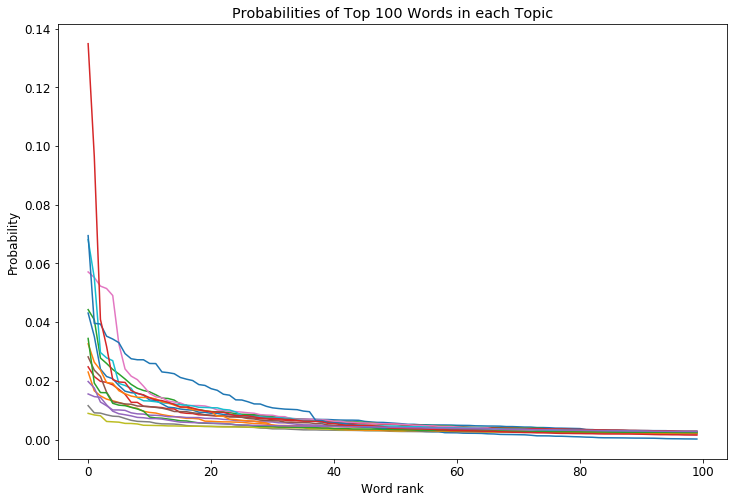

In [116]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 12, 8 
plt.rcParams['font.size'] = 12

# top 100 words by weight in each topic
top_n_words = 100
topics = lda_model.show_topics(
    num_topics = 16, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
plt.show()

In [60]:
'''
In the above plot, each line corresponds to one of our 15 topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10 to 20 words in each topic are assigned a much greater weight than the remaining words'''

'\nIn the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10 to 20 words in each topic are assigned a much greater weight than the remaining words'

In [117]:
sent_topics_df = a[["clean_text"]]

In [118]:
sent_topics_df["topic"]= a['topic_prob'].map(lambda token: token[0])
sent_topics_df["Perc_Contribution"]= a['topic_prob'].map(lambda token: token[1])

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [119]:
sent_topics_df

,clean_text,topic,Perc_Contribution
0,"[australian, senat, provok, outrag, blame, isl...",7,0.379320
1,"[media, playback, unsupport, devic, media, chr...",12,0.562233
2,"[lord, steel, evid, independ, inquiri, child, ...",5,0.226073
3,"[driver, fin, blare, music, loudli, road, biza...",1,0.479112
4,"[love, warm, posh, hot, chocol, save, mar, twi...",2,0.632381
...,...,...,...
28200,"[conserv, leadership, field, slim, bori, johns...",11,0.682785
28201,"[sign, news, alert, citi, boss, suspend, buy, ...",8,0.277748
28202,"[ian, wright, open, warn, children, racism, yo...",4,0.325265
28203,"[amazon, echo, voic, vodafon, deal, amazon, ec...",1,0.397461


In [222]:
def kew(topic_num):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return(topic_keywords)

In [223]:
sent_topics_df["topic_keywords"]= sent_topics_df["topic"].map(lambda token: kew(token))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
sent_topics_df

,clean_text,topic,Perc_Contribution
0,"[australian, senat, provok, outrag, blame, isl...",7,0.379320
1,"[media, playback, unsupport, devic, media, chr...",12,0.562233
2,"[lord, steel, evid, independ, inquiri, child, ...",5,0.226073
3,"[driver, fin, blare, music, loudli, road, biza...",1,0.479112
4,"[love, warm, posh, hot, chocol, save, mar, twi...",2,0.632381
...,...,...,...
28200,"[conserv, leadership, field, slim, bori, johns...",11,0.682785
28201,"[sign, news, alert, citi, boss, suspend, buy, ...",8,0.277748
28202,"[ian, wright, open, warn, children, racism, yo...",4,0.325265
28203,"[amazon, echo, voic, vodafon, deal, amazon, ec...",1,0.397461


In [283]:
topic_labels ={0:"Health",1:"Pension",2:"Shopping",
               3:"Advertisement",4:"Celebrity",5:"Crime",6:"Sports",
               7:"International relations",8:"Premier league",
               9:"Road safety",10:"Air travel",11:"Brexit",12:"murder",13:"Trump",14:"lifestyle"}
empt=[]
for i in sent_topics_df['topic'].value_counts().index:
    empt.append(topic_labels[i])
sent_topics_df['topic'].value_counts()

12    5311
8     4586
4     4050
11    3770
7     3516
1     2871
5     1317
14     841
3      725
2      467
9      372
0      219
13      95
6       48
10      17
Name: topic, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

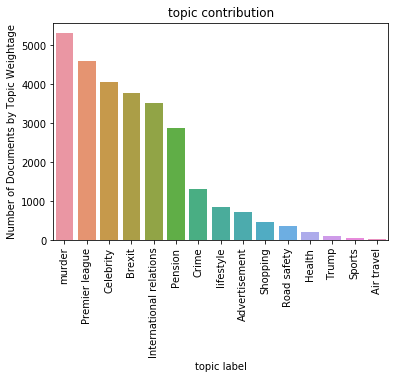

In [285]:
import seaborn 
ax=seaborn.barplot(x=empt, y=sent_topics_df['topic'].value_counts())
ax.set_title('topic contribution')
ax.set_ylabel('Number of Documents by Topic Weightage')
ax.set_xlabel('topic label')
plt.xticks(rotation=90)

In [122]:
def closest(topic_num, doc_num):
    v= sent_topics_df[sent_topics_df["topic"]==topic_num]
    v= v.nlargest(doc_num, 'Perc_Contribution')
    return(v)

In [265]:
new_list=closest(0,200)
new_list

,clean_text,topic,Perc_Contribution,topic_keywords
62,"[vaccin, hesit, persist, bodi, evid, mmr, vacc...",0,0.724557,"health, univers, studi, food, dr, credit, risk..."
96,"[eat, egg, day, rais, risk, heart, diseas, ear...",0,0.714103,"health, univers, studi, food, dr, credit, risk..."
10063,"[scottish, daili, express, lead, claim, common...",0,0.583420,"health, univers, studi, food, dr, credit, risk..."
27733,"[eat, red, meat, cut, life, expect, scientist,...",0,0.549487,"health, univers, studi, food, dr, credit, risk..."
23269,"[eat, cup, blueberri, day, slash, risk, develo...",0,0.532435,"health, univers, studi, food, dr, credit, risk..."
...,...,...,...,...
20415,"[univers, bristol, particip, cat, happi, meet,...",0,0.210843,"health, univers, studi, food, dr, credit, risk..."
11607,"[stanford, univers, clear, stephen, quak, bioe...",0,0.210551,"health, univers, studi, food, dr, credit, risk..."
25495,"[patient, ill, die, listeria, credit, hospit, ...",0,0.209454,"health, univers, studi, food, dr, credit, risk..."
21226,"[citi, catch, sti, reveal, bad, news, live, ca...",0,0.209274,"health, univers, studi, food, dr, credit, risk..."


In [266]:
print(''.join(map(str, new_list["topic_keywords"][5495])))

health, univers, studi, food, dr, credit, risk, bodi, drug, diseas


In [267]:
print(''.join(map(str, a["text"][5495])))

Children in low-income families suffer social exclusion and a sense of shame because they do not have enough food to eat, according to research published by the Child Poverty Action Group (CPAG).

Many do not qualify for free school meals; even when they do, the lunches can be insufficient for teenagers, and some children from families who have no recourse to public funds (NRPF) because of their parents’ immigration status do not eat at all during the school day.

The UCL study, Living Hand to Mouth: Children and Food in Low-income Families, includes conversations with 51 children from low-income families in south-east England who describe their experiences of food at home, school and in social settings.

The interviews, which form part of a larger European study of food poverty among children and families in Portugal, Norway and the UK, offer a rare insight into children’s lived experience of food poverty.

Some told how schools identify children on free school meals (FSM) by restrict

In [290]:
a

,index,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length,topic_prob
0,1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302,"(7, 0.37932003)"
1,3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr...",467,"(12, 0.56223345)"
2,4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[lord, steel, evid, independ, inquiri, child, ...",378,"(5, 0.22607288)"
3,6,You can now be fined £100 for blaring loud mus...,DRIVERS can now be fined for blaring music too...,[Molly Rose Pike],[http://www.facebook.com/tr?id=752905198150451...,None,en,"[bradford, bradford council]",GER_2019-03-15_2103_web_page.html,www.thesun.co.uk/news/8639972/fined-100-blarin...,NaN,uk,1.0,1.0,"[driver, fin, blare, music, loudli, road, biza...",259,"(1, 0.47911218)"
4,7,Aldi’s selling Twix and Mars hot chocolate pod...,IF you love warming up with a posh hot chocola...,"[Alice Grahns, Digital Consumer Reporter]",[http://www.facebook.com/tr?id=752905198150451...,None,en,"[Mars, Twix, hot chocolate, pods, Dolce Gusto,...",GER_2019-03-15_2925_web_page.html,www.thesun.co.uk/money/8276540/aldi-selling-tw...,NaN,uk,1.0,1.0,"[love, warm, posh, hot, chocol, save, mar, twi...",244,"(2, 0.6323806)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28200,36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns...",384,"(11, 0.68278515)"
28201,36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ...",134,"(8, 0.2777481)"
28202,36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, racism, yo...",285,"(4, 0.32526493)"
28203,36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, vodafon, deal, amazon, ec...",160,"(1, 0.39746064)"


In [ ]:
doc_lens = list(a["length"])

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  400, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  200, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  100, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()